### Data Loading

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt

from processing_utils.feature_data_from_mat import load_subject_high_gamma

Load in S14 Data

In [2]:
S14_hg_trace, S14_hg_map, S14_phon_labels = load_subject_high_gamma('S14', sig_channel=False, zscore=False)

(149, 200, 128)
(149, 8, 16, 200)
(149, 3)


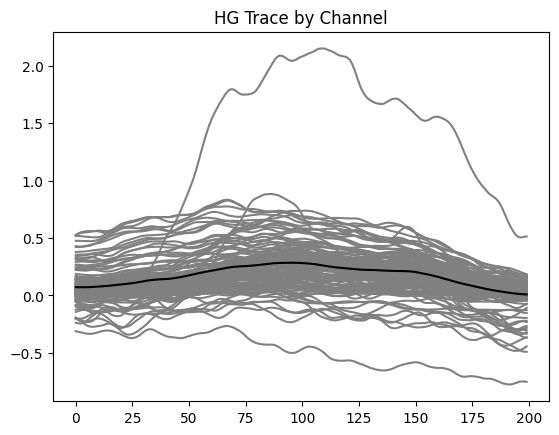

In [3]:
print(S14_hg_trace.shape)
print(S14_hg_map.shape)
print(S14_phon_labels.shape)

plt.figure()
plt.plot(np.mean(S14_hg_trace, axis=0), 'grey')
plt.plot(np.mean(np.mean(S14_hg_trace, axis=0), axis=1), 'black')
plt.title('HG Trace by Channel')
plt.show()

Load in S26 Data

In [4]:
S26_hg_trace, S26_hg_map, S26_phon_labels = load_subject_high_gamma('S26', sig_channel=False, zscore=False)

(152, 200, 128)
(152, 8, 16, 200)
(152, 3)


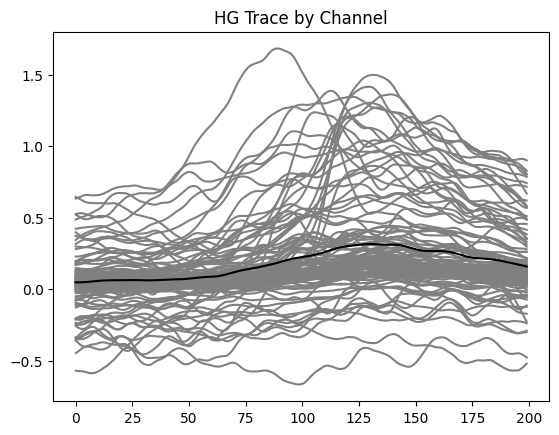

In [5]:
print(S26_hg_trace.shape)
print(S26_hg_map.shape)
print(S26_phon_labels.shape)

plt.figure()
plt.plot(np.mean(S26_hg_trace, axis=0), 'grey')
plt.plot(np.mean(np.mean(S26_hg_trace, axis=0), axis=1), 'black')
plt.title('HG Trace by Channel')
plt.show()

Process data for use with 1/3 D CNN Bidirectional LSTM seq2seq

In [6]:
# imports
from processing_utils.sequence_processing import pad_sequence_teacher_forcing

In [7]:
# parameters
n_output = 10

In [8]:
X1 = S14_hg_trace  # use HG traces (n_trials, n_channels, n_timepoints) for 1D CNN
# X1 = S14_hg_map  # use HG channel map stack (n_trials, n_channels_x, n_channels_y, n_timepoints) for 1D CNN
X1_prior, y1, prior1_labels, seq1_labels = pad_sequence_teacher_forcing(S14_phon_labels, n_output)  # first 2 outputs one-hot encoded

In [9]:
print(X1.shape, X1_prior.shape, y1.shape, prior1_labels.shape, seq1_labels.shape)

(149, 200, 128) (149, 3, 10) (149, 3, 10) (149, 3) (149, 3)


In [10]:
X2 = S26_hg_trace  # use HG traces (n_trials, n_channels, n_timepoints) for 1D CNN
# X2 = S26_hg_map  # use HG channel map stack (n_trials, n_channels_x, n_channels_y, n_timepoints) for 1D CNN
X2_prior, y2, prior2_labels, seq2_labels = pad_sequence_teacher_forcing(S26_phon_labels, n_output)  # first 2 outputs one-hot encoded

In [11]:
print(X2.shape, X2_prior.shape, y2.shape, prior2_labels.shape, seq2_labels.shape)

(152, 200, 128) (152, 3, 10) (152, 3, 10) (152, 3) (152, 3)


Build 1D CNN Bidirectional LSTM seq2seq Model

In [12]:
# imports
from seq2seq_models.rnn_models import lstm_1Dcnn_model

In [13]:
# parameters

# 1D CNN
n_input_time = X1.shape[1]
n_input_channel = X1.shape[2]
filter_size = 10

# 3D CNN
# n_input_channel = [X.shape[1], X.shape[2]]
# n_input_time = X.shape[3]
# filter_size = 2

n_filters = 100
n_units = 800
reg_lambda = 1e-6
bidir = False

In [14]:
train_model, inf_enc, inf_dec = lstm_1Dcnn_model(n_input_time, n_input_channel, n_output, n_filters, filter_size, n_units, reg_lambda, bidir=bidir)

In [15]:
print(train_model.summary())
print(train_model.layers[-1].summary())
print(inf_enc.summary())
print(inf_enc.layers[-1].summary())
print(inf_dec.summary())

Model: "training_lstm_final"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 128)]   0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 20, 100)      128100      ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, None, 10)]   0           []                               
                                                                                                  
 training_lstm_initial (Functio  (None, None, 10)    5486410     ['conv1d[0][0]',                 
 nal)                                                             'input_2[0][0]

Training

In [16]:
# imports
from keras.optimizers import Adam
from train.transfer_training import transfer_seq2seq_kfold

In [17]:
# parameters
num_folds = 2
batch_size = 150
epochs = 500
learning_rate = 1e-3

train_model.compile(optimizer=Adam(learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
models, histories, y_pred_all, y_test_all = transfer_seq2seq_kfold(train_model, inf_enc, inf_dec, X1, X1_prior, y1, X2, X2_prior, y2, num_folds=num_folds)

========== Fold 1 ==========
Epoch 1/200
5/5 [==============================] - 7s 243ms/step - loss: 2.3258 - accuracy: 0.1186
Epoch 2/200
5/5 [==============================] - 1s 245ms/step - loss: 2.1425 - accuracy: 0.1879
Epoch 3/200
5/5 [==============================] - 1s 257ms/step - loss: 2.0446 - accuracy: 0.2148
Epoch 4/200
5/5 [==============================] - 1s 243ms/step - loss: 1.9090 - accuracy: 0.3110
Epoch 5/200
5/5 [==============================] - 1s 261ms/step - loss: 1.8054 - accuracy: 0.3535
Epoch 6/200
5/5 [==============================] - 1s 294ms/step - loss: 1.6457 - accuracy: 0.3960
Epoch 7/200
5/5 [==============================] - 1s 280ms/step - loss: 1.5296 - accuracy: 0.4720
Epoch 8/200
5/5 [==============================] - 1s 245ms/step - loss: 1.3440 - accuracy: 0.5548
Epoch 9/200
5/5 [==============================] - 1s 240ms/step - loss: 1.1440 - accuracy: 0.6152
Epoch 10/200
5/5 [==============================] - 1s 242ms/step - loss: 0.9390

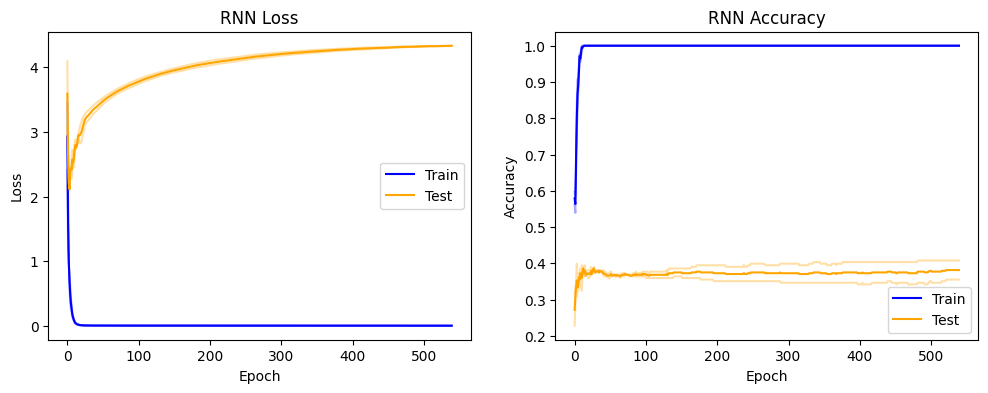

In [19]:
# from visualization.plot_model_performance import extend_history_lists

# histories = extend_history_lists(histories, epochs=epochs)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(np.array(histories['loss']).T, color='blue', alpha=0.35)
ax1.plot(np.mean(histories['loss'], axis=0), color='blue', label='Train')
ax1.plot(np.array(histories['val_loss']).T, color='orange', alpha=0.35)
ax1.plot(np.mean(histories['val_loss'], axis=0), color='orange', label='Test')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('RNN Loss')
ax1.legend()

ax2.plot(np.array(histories['accuracy']).T, color='blue', alpha=0.35)
ax2.plot(np.mean(histories['accuracy'], axis=0), color='blue', label='Train')
ax2.plot(np.array(histories['val_accuracy']).T, color='orange', alpha=0.35)
ax2.plot(np.mean(histories['val_accuracy'], axis=0), color='orange', label='Test')
# ax2.axhline(1/(n_output-1), color='gray', linestyle='--', label='Chance')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('RNN Accuracy')
ax2.legend()

plt.show()

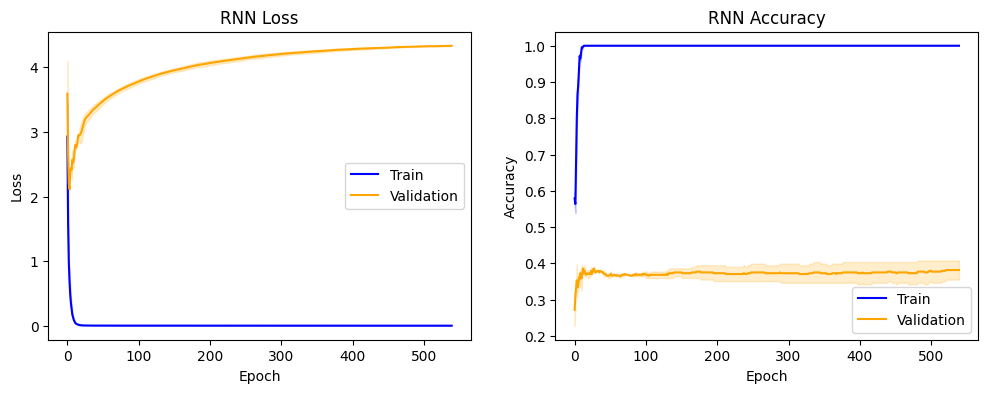

In [20]:
from visualization.plot_model_performance import plot_accuracy_loss

plot_accuracy_loss(histories, epochs=540)

In [21]:
from sklearn.metrics import balanced_accuracy_score

print('Balanced Accuracy: ', balanced_accuracy_score(y_test_all, y_pred_all))

Balanced Accuracy:  0.3485511566118225
